In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
sns.set_style('whitegrid')

# Указание пути до всех csv файлов и их загрузка

In [2]:
comp_dir = Path('store-sales-time-series-forecasting')

In [3]:
df_holidays = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'])

df_oil = pd.read_csv(comp_dir /'oil.csv', header = 0)
df_stores = pd.read_csv(comp_dir / 'stores.csv', header = 0)
df_trans = pd.read_csv(comp_dir / 'transactions.csv', header = 0)

df_train = pd.read_csv(comp_dir / 'train.csv', header = 0)
df_test = pd.read_csv(comp_dir / 'test.csv', header = 0)

In [4]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'], format = "%Y-%m-%d")
df_holidays = df_holidays.set_index('date').to_period('D')
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
df_train['date'] = pd.to_datetime(df_train['date'], format = "%Y-%m-%d")
df_test['date'] = pd.to_datetime(df_test['date'], format = "%Y-%m-%d")

# Просмотр содержимого загруженных данных

In [5]:
df_holidays.head(10)

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False


In [6]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [7]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
df_trans.head()


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,2483653,2016-10-28,46,CLEANING,2576.000,61
1,2761877,2017-04-03,52,DAIRY,0.000,0
2,1217988,2014-11-16,33,MEATS,357.354,2
3,1231938,2014-11-24,25,HOME AND KITCHEN I,5.000,0
4,528175,2013-10-24,29,EGGS,0.000,0


In [10]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [11]:
def grouped(df, key, freq, col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [12]:
df_grouped_trans_w = grouped(df_trans, 'date', 'W', 'transactions')
df_grouped_trans_w

,date,mean
0,2013-01-06,1883.203463
1,2013-01-13,1641.090062
2,2013-01-20,1639.024845
3,2013-01-27,1609.816770
4,2013-02-03,1685.263975
...,...,...
237,2017-07-23,1623.208995
238,2017-07-30,1619.653439
239,2017-08-06,1713.743386
240,2017-08-13,1599.156085


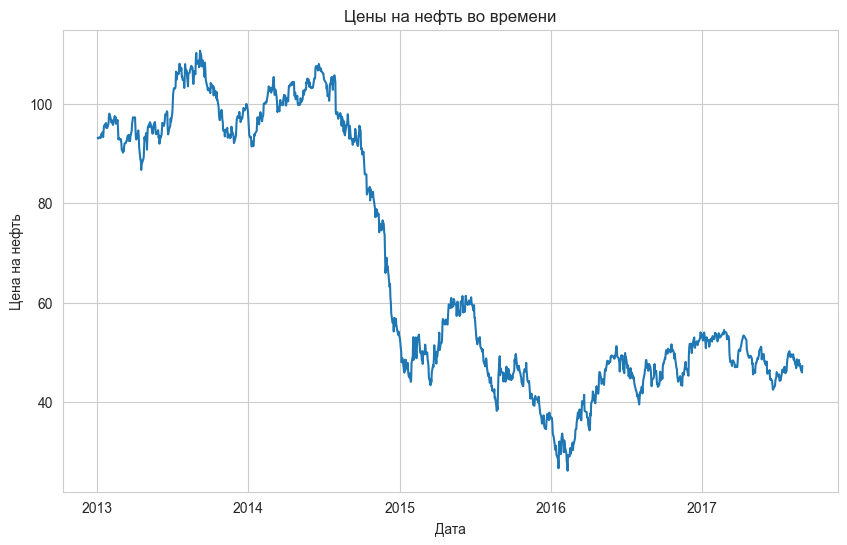

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_oil, x='date', y='dcoilwtico')
plt.title('Цены на нефть во времени')
plt.xlabel('Дата')
plt.ylabel('Цена на нефть')
plt.show()



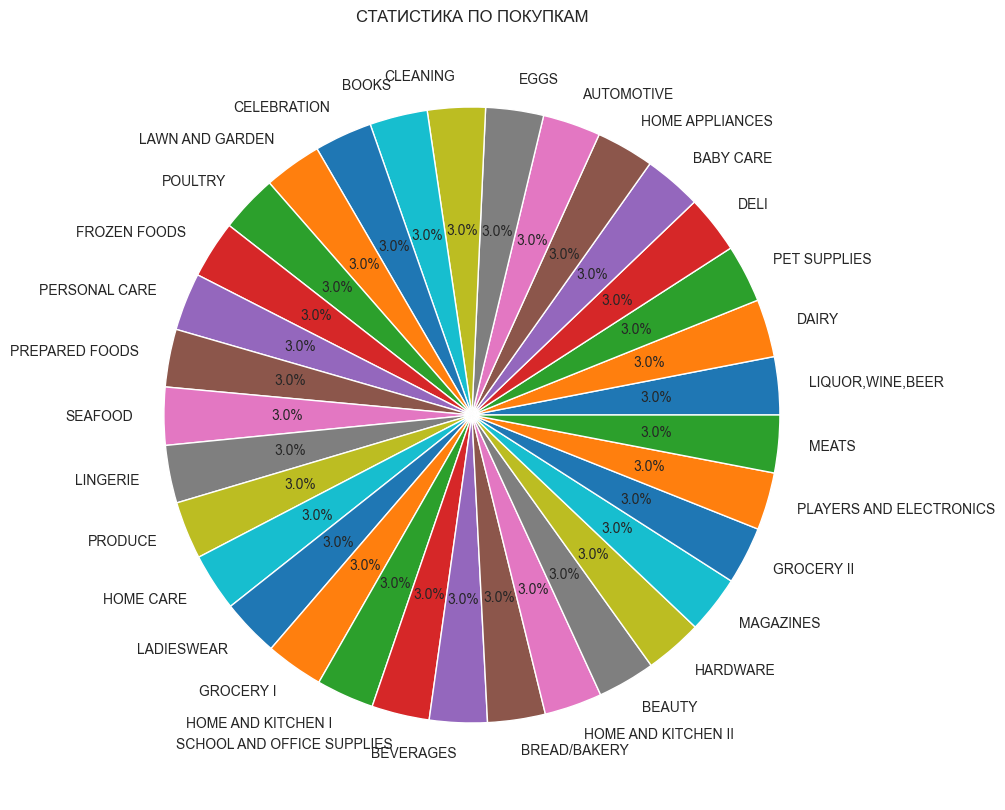

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
count_classes = df_train['family'].value_counts()
plt.title("Статистика по покупкам".upper())

plt.pie(count_classes, 
        labels = count_classes.index, 
        autopct='%1.1f%%')

plt.show()

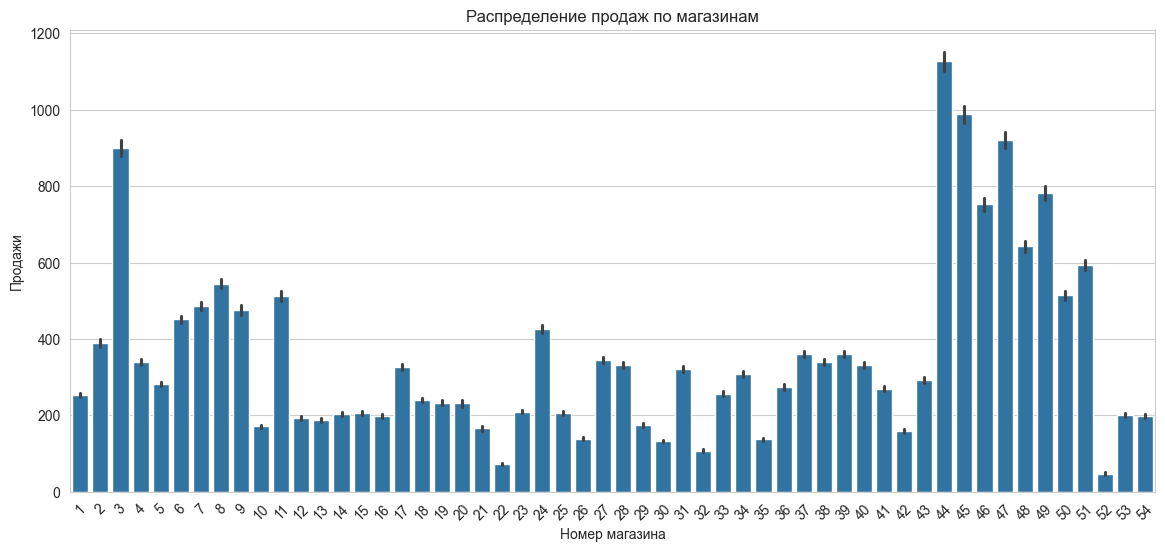

In [15]:
plt.figure(figsize=(14, 6))
sns.barplot(data=df_train, x='store_nbr', y='sales')
plt.title('Распределение продаж по магазинам')
plt.xlabel('Номер магазина')
plt.ylabel('Продажи')
plt.xticks(rotation=45)
plt.show()


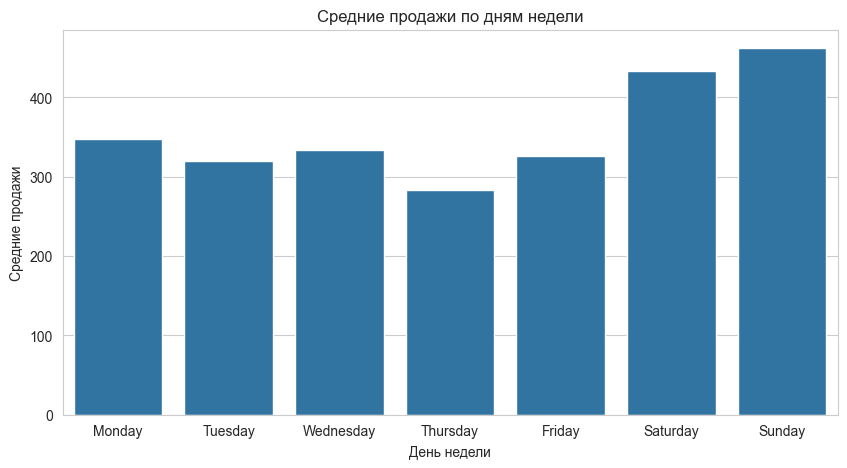

In [16]:
df_train['day_of_week'] = df_train['date'].dt.day_name()  # Извлечение названия дня недели из даты
avg_sales_day = df_train.groupby('day_of_week')['sales'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_sales_day.index, y=avg_sales_day.values)
plt.title('Средние продажи по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средние продажи')
plt.show()


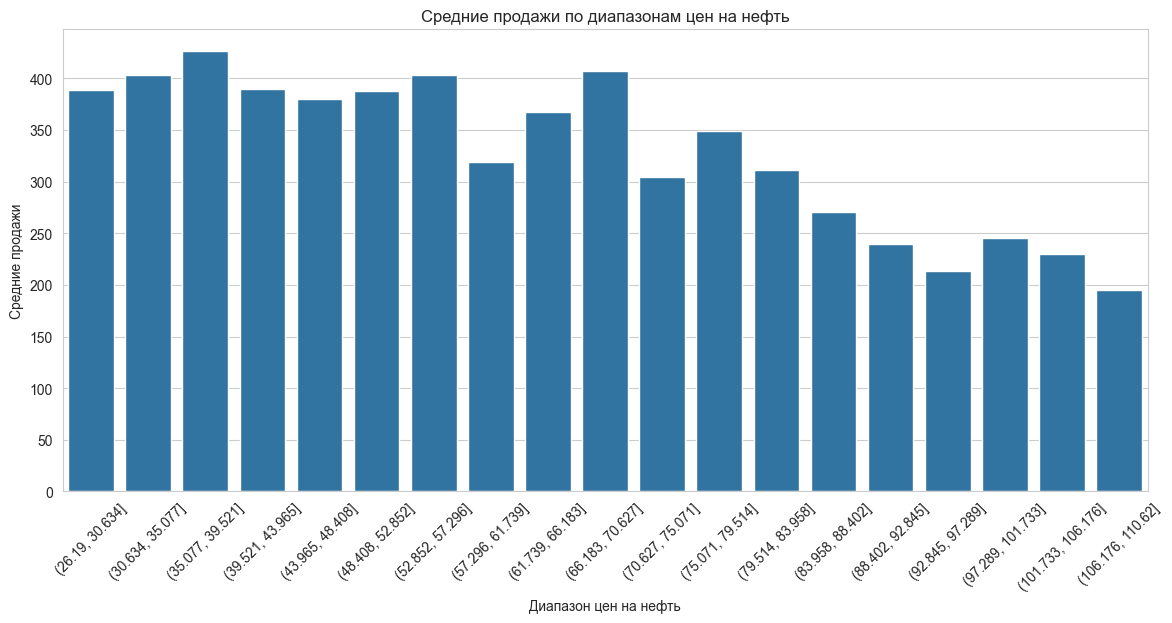

In [17]:
# Объединение данных по дате
df_combined = pd.merge(df_train, df_oil, how='left', on='date')

df_combined['oil_price_bin'] = pd.cut(df_combined['dcoilwtico'], bins=np.linspace(df_combined['dcoilwtico'].min(), df_combined['dcoilwtico'].max(), 20))
df_aggregated = df_combined.groupby('oil_price_bin', observed=True).agg(mean_sales=('sales', 'mean')).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x='oil_price_bin', y='mean_sales', data=df_aggregated)
plt.xticks(rotation=45)
plt.title('Средние продажи по диапазонам цен на нефть')
plt.xlabel('Диапазон цен на нефть')
plt.ylabel('Средние продажи')
plt.show()


In [18]:
missing_values = df_combined.isnull().sum()
print("Пропущенные значения в данных:")
print(missing_values[missing_values > 0])


Пропущенные значения в данных:
dcoilwtico       742994
oil_price_bin    744441
dtype: int64


In [19]:
# Получение наиболее частого значения в столбце
mode_value = df_combined['oil_price_bin'].mode()[0]

df_combined['oil_price_bin'].fillna(mode_value, inplace=True)
df_combined.isnull().sum()


C:\Users\Nasdorm\AppData\Local\Temp\ipykernel_9144\65771087.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['oil_price_bin'].fillna(mode_value, inplace=True)


id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
day_of_week           0
dcoilwtico       742994
oil_price_bin         0
dtype: int64

In [20]:
# Преобразование столбца с датой в формат datetime
df_combined['date'] = pd.to_datetime(df_combined['date'])

In [21]:
# Добавление временных признаков
df_combined['month'] = df_combined['date'].dt.month
df_combined['day_of_week'] = df_combined['date'].dt.dayofweek

# Пример добавления лаговых признаков
df_combined['lag_1'] = df_combined['sales'].shift(1)
df_combined['lag_7'] = df_combined['sales'].shift(7)

df_combined['oil_price_bin']

0            (48.408, 52.852]
1            (48.408, 52.852]
2            (43.965, 48.408]
3            (75.071, 79.514]
4            (92.845, 97.289]
                  ...        
2400705    (101.733, 106.176]
2400706      (30.634, 35.077]
2400707      (52.852, 57.296]
2400708      (43.965, 48.408]
2400709      (43.965, 48.408]
Name: oil_price_bin, Length: 2400710, dtype: category
Categories (19, interval[float64, right]): [(26.19, 30.634] < (30.634, 35.077] < (35.077, 39.521] < (39.521, 43.965] ... (92.845, 97.289] < (97.289, 101.733] < (101.733, 106.176] < (106.176, 110.62]]

In [22]:
df_combined.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'day_of_week', 'dcoilwtico', 'oil_price_bin', 'month', 'lag_1',
       'lag_7'],
      dtype='object')